In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Introduction

In today's exercise, we will take the gauge configurations generated by last Friday's notebook, and smear them. Smearing the gauge configurations will improve the signal to noise ratios on measured quantities such as the static quark potential. The end goal will be to have a plot like this:

![example](LGT1-Unit02-Day09_smearing_fig1.png)

To get started, download the file `SU2_L8Lt16_beta2.5_hb.npy' and place it in the same directory as this notebook. This file contains 40 gauge configurations generated from last Friday's notebook. (Alternatively, you can generate the configurations from last Friday's notebook yourself, and save and reload them in this notebook). The shape of this array is described by:

(Configuration number, dimension that the gauge link is pointing, x,y,z,t, colour1, colour2)

In [2]:
gauge = np.load('LGT1-Unit02-Day09_smearing_gauge.npy')
gauge.shape

(40, 4, 8, 8, 8, 16, 2, 2)

Here, we have some helper code that we've seen from previous lectures, 

In [3]:
def trace(X):
    """
    Returns the trace of a (...,Nc,Nc) shaped tensor
    """
    Nc = X.shape[-1]
    return np.trace(X,axis1=-1,axis2=-2)/Nc

def adjoint(X):
    """
    Returns the adjoint (dagger) of a (...,Nc,Nc) shaped tensor
    """
    return np.conj(np.moveaxis(X,-1,-2))

def plaq(X,i,j):
    """
    Returns the average real value of the plaquette (normalised by Nc) in the
    i-th and j-th spacetime dimensions
    """
    Nc = X.shape[-1]
    return np.real(np.average(trace(X[i]@np.roll(X[j],-1,axis=i)@\
                                adjoint(np.roll(X[i],-1,axis=j))@adjoint(X[j]))))/Nc

def wilson_loop(U, mu, nu, l_mu, l_nu):
    """
    Computes the Wilson Loop on the gauge configuration
    U.shape = (4,L,L,L,LT,Nc,Nc)
    where the loop points in the (mu,nu) directions with lengths (l_mu,l_nu)
    """
    Nc = U.shape[-1]
    W = np.broadcast_to(np.eye(Nc, Nc), U.shape[1:])
    for x in range(l_mu):
        W = W @ np.roll(U[mu], -x, mu)
    for y in range(l_nu):
        W = W @ np.roll(U[nu], (-l_mu, -y), (mu, nu))
    for x in reversed(range(l_mu)):
        W = W @ np.roll(adjoint(U[mu]), (-x, -l_nu), (mu, nu))
    for y in reversed(range(l_nu)):
        W = W @ np.roll(adjoint(U[nu]), -y, nu)
    return np.mean(trace(W.real))

def V(chain,max_x,t):
    """
    Computes the static quark potential on a chain of gauge configurations
    chain.shape = (N_samples, 4,L,L,L,Lt,Nc,Nc)
    for dx in [1,max_x) and using the effective mass at time t.
    Returns the average and (bootstrapped) error
    """
    w = np.zeros((len(chain),max_x-1,2))
    for i,U in enumerate(chain):
        if i%10 == 0:
            print(f"Iter {i}/{len(chain)}")
        for dx in range(1,max_x):
            for dt in [t,t+1]:
                w[i,dx-1,dt-t] = w[i,dx-1,dt-t] + wilson_loop(U,0,3,dx,dt)
                w[i,dx-1,dt-t] = w[i,dx-1,dt-t] + wilson_loop(U,1,3,dx,dt)
                w[i,dx-1,dt-t] = w[i,dx-1,dt-t] + wilson_loop(U,2,3,dx,dt)
                
    bstrps = np.average(w[[np.random.randint(size=(20,len(chain)),low=0,high=len(chain))]][0],axis=1)
    V = -np.log(bstrps[:,:,1]/bstrps[:,:,0])
    return np.average(V,axis=0),np.std(V,axis=0)

In [4]:
#Let's compute the unsmeared static quark potential
V_av,V_std = V(gauge,7,3)

Iter 0/40
Iter 10/40
Iter 20/40
Iter 30/40


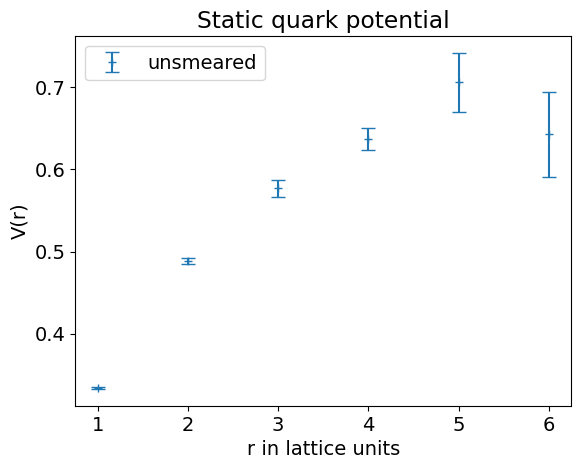

In [5]:
plt.rcParams.update({'font.size': 14})
plt.errorbar(range(1,7),V_av,V_std,fmt='+',capsize=5,label='unsmeared')
plt.title("Static quark potential")
plt.ylabel("V(r)")
plt.xlabel("r in lattice units")
plt.legend()
plt.show()

Now, try and smear the gauge fields to get an improved signal! I recommend trying stout smearing steps, for Nc = 2 the formula simplifies to the following:

![smearing](LGT1-Unit02-Day09_smearing_fig2.jpg)

Try 10 steps of smearing with epsilon = 0.01. 